# MIT-GSL Uruguay 

## January 2020

-----

# Week - 2 | Class project 
# NLP: Generating product emebddings from descriptions

**Overview**

1. The following hands on exercise focuses on the application of techniques discussed during the lecture series and the hands on programming session
2. The exercise aims to extend our understanding of word embeddings
3. The exercise is scheduled for 2 hours
4. We will use 90 minutes for working through the problem and the remaining 30 minutes for questions and discussion

----

# Instructions:

## Setting:

1. We have imported pre-trained word vectors from GloVe (https://nlp.stanford.edu/projects/glove/):
2. The vectors have been mapped to product names in the product dataset
3. Based on the product name vectors we will try to understand relationships between products

## Your task:

---

# Instacart Grocery Dataset

### Source: https://www.instacart.com/datasets/grocery-shopping-2017

1. Instacart is an online grocery delivery service
2. They have made available 3M grocery orders for over 200K users
3. They provide between 4 to 100 orders for each user and each order contains the sequence of products purchased
4. We also have a brief description of the products

### Overview:
1. We will use this data to build an understanding of word embeddings and investigate their application to downstream tasks
2. For this purpose, we will consider each purchase basket to be a sentence with an unordered sequence of words

---

In [1]:
# ==============================================
# 0. Module imports
# ==============================================

import pandas as pd
pd.options.display.max_colwidth = 100
import numpy as np
from itertools import product
import csv
import collections
import random

# w2v
import gensim

# text processing
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import ToktokTokenizer
import string
import re # regular expressions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

# T-Sne
#import umap
#from openTSNE import TSNE, TSNEEmbedding, affinity, initialization
#from openTSNE import initialization
#from openTSNE.callbacks import ErrorLogger
from sklearn.manifold import TSNE


# utils
from sklearn import utils


# parallel processing
import multiprocessing
from joblib import delayed, Parallel

# time code
import time

# 2-d visualiztion
%matplotlib inline
from ggplot import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import os
os.chdir("/pool001/madhavk/gsl-uruguay/W-02-NLP/")

/home/software/sloan/local/lib/py36/cryptography/hazmat/bindings/openssl/binding.py:163: CryptographyDeprecationWarning: OpenSSL version 1.0.1 is no longer supported by the OpenSSL project, please upgrade. A future version of cryptography will drop support for it.
  utils.CryptographyDeprecationWarning
/home/software/sloan/local/lib/py36/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/software/sloan/local/lib/py36/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/software/sloan/local/lib/py36/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  

In [2]:
# =========================================================
# set directories
# =========================================================

# raw data
raw_data_dir = "nlp-data/in-grocery/instacart_2017_05_01/"

# processed data
process_dir = "nlp-data/in-grocery/prepared-data/"

In [3]:
# =========================================================
# processed files
# =========================================================

os.listdir(process_dir)

['orders-split-v1.csv',
 'all-orders-wide-v1.csv',
 'all-orders-long-v1.csv',
 'products-merged-v1.csv']

In [4]:
# =========================================================
# global parameters
# =========================================================

# show entire value of cell in pandas
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

# number of cpus
cpus = multiprocessing.cpu_count()
f"Number of CPUs: {cpus}"

'Number of CPUs: 28'

----

# 1. Import data

## 1.1. Import product info data

In [5]:
products = pd.read_csv(process_dir + "products-merged-v1.csv")
print(products.shape)

(49688, 6)


In [6]:
display(products.head(10))

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry
5,6,Dry Nose Oil,11,11,cold flu allergy,personal care
6,7,Pure Coconut Water With Orange,98,7,juice nectars,beverages
7,8,Cut Russet Potatoes Steam N' Mash,116,1,frozen produce,frozen
8,9,Light Strawberry Blueberry Yogurt,120,16,yogurt,dairy eggs
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7,water seltzer sparkling water,beverages


In [7]:
#===============================================
# top departments
#===============================================
products["department"].value_counts()

personal care      6563
snacks             6264
pantry             5371
beverages          4365
frozen             4007
dairy eggs         3449
household          3085
canned goods       2092
dry goods pasta    1858
produce            1684
bakery             1516
deli               1322
missing            1258
international      1139
breakfast          1115
babies             1081
alcohol            1054
pets               972 
meat seafood       907 
other              548 
bulk               38  
Name: department, dtype: int64

In [8]:
#===============================================
# top aisles
#===============================================
products["aisle"].value_counts()

missing                          1258
candy chocolate                  1246
ice cream ice                    1091
vitamins supplements             1038
yogurt                           1026
chips pretzels                   989 
tea                              894 
packaged cheese                  891 
frozen meals                     880 
cookies cakes                    874 
energy granola bars              832 
hair care                        816 
spices seasonings                797 
juice nectars                    792 
crackers                         747 
soup broth bouillon              737 
baby food formula                718 
coffee                           680 
refrigerated                     675 
cleaning products                655 
baking ingredients               623 
packaged vegetables fruits       615 
asian foods                      605 
nuts seeds dried fruit           582 
fresh vegetables                 569 
oral hygiene                     565 
salad dressi

----

## 1.2. Import pre-trained word vectors

In [9]:
#===============================================
# glove embeddings
#===============================================

glove = pd.read_table("/pool001/madhavk/gsl-uruguay/W-02-NLP/nlp-data/in-grocery/glove/glove.6B.50d.txt",
                      sep = " ", header = None, 
                      quoting = csv.QUOTE_NONE)
print(glove.shape)

(400000, 51)


In [10]:
display(glove.head(30))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
0,the,0.418000,0.249680,-0.412420,0.121700,0.345270,-0.044457,-0.496880,-0.178620,-0.000660,-0.656600,0.278430,-0.147670,-0.556770,0.146580,-0.009510,0.011658,0.102040,-0.127920,-0.844300,-0.121810,-0.016801,-0.332790,-0.155200,-0.231310,-0.191810,-1.88230,-0.767460,0.099051,-0.421250,-0.195260,4.0071,-0.185940,-0.522870,-0.316810,0.000592,0.007445,0.177780,-0.158970,0.012041,-0.054223,-0.298710,-0.157490,-0.347580,-0.045637,-0.442510,0.187850,0.002785,-0.184110,-0.115140,-0.785810
1,",",0.013441,0.236820,-0.168990,0.409510,0.638120,0.477090,-0.428520,-0.556410,-0.364000,-0.239380,0.130010,-0.063734,-0.395750,-0.481620,0.232910,0.090201,-0.133240,0.078639,-0.416340,-0.154280,0.100680,0.488910,0.312260,-0.125200,-0.037512,-1.51790,0.126120,-0.024420,-0.042961,-0.283510,3.5416,-0.119560,-0.014533,-0.149900,0.218640,-0.334120,-0.138720,0.318060,0.703580,0.448580,-0.080262,0.630030,0.321110,-0.467650,0.227860,0.360340,-0.378180,-0.566570,0.044691,0.303920
2,.,0.151640,0.301770,-0.167630,0.176840,0.317190,0.339730,-0.434780,-0.310860,-0.449990,-0.294860,0.166080,0.119630,-0.413280,-0.423530,0.598680,0.288250,-0.115470,-0.041848,-0.679890,-0.250630,0.184720,0.086876,0.465820,0.015035,0.043474,-1.46710,-0.303840,-0.023441,0.305890,-0.217850,3.7460,0.004228,-0.184360,-0.462090,0.098329,-0.119070,0.239190,0.116100,0.417050,0.056763,-0.000064,0.068987,0.087939,-0.102850,-0.139310,0.223140,-0.080803,-0.356520,0.016413,0.102160
3,of,0.708530,0.570880,-0.471600,0.180480,0.544490,0.726030,0.181570,-0.523930,0.103810,-0.175660,0.078852,-0.362160,-0.118290,-0.833360,0.119170,-0.166050,0.061555,-0.012719,-0.566230,0.013616,0.228510,-0.143960,-0.067549,-0.381570,-0.236980,-1.70370,-0.866920,-0.267040,-0.258900,0.176700,3.8676,-0.161300,-0.132730,-0.688810,0.184440,0.005246,-0.338740,-0.078956,0.241850,0.365760,-0.347270,0.284830,0.075693,-0.062178,-0.389880,0.229020,-0.216170,-0.225620,-0.093918,-0.803750
4,to,0.680470,-0.039263,0.301860,-0.177920,0.429620,0.032246,-0.413760,0.132280,-0.298470,-0.085253,0.171180,0.224190,-0.100460,-0.436530,0.334180,0.678460,0.057204,-0.344480,-0.427850,-0.432750,0.559630,0.100320,0.186770,-0.268540,0.037334,-2.09320,0.221710,-0.398680,0.209120,-0.557250,3.8826,0.474660,-0.956580,-0.377880,0.208690,-0.327520,0.127510,0.088359,0.163510,-0.216340,-0.094375,0.018324,0.210480,-0.030880,-0.197220,0.082279,-0.094340,-0.073297,-0.064699,-0.260440
5,and,0.268180,0.143460,-0.278770,0.016257,0.113840,0.699230,-0.513320,-0.473680,-0.330750,-0.138340,0.270200,0.309380,-0.450120,-0.412700,-0.099320,0.038085,0.029749,0.100760,-0.250580,-0.518180,0.345580,0.449220,0.487910,-0.080866,-0.101210,-1.37770,-0.108660,-0.232010,0.012839,-0.465080,3.8463,0.313620,0.136430,-0.522440,0.330200,0.337070,-0.356010,0.324310,0.120410,0.351200,-0.069043,0.368850,0.251680,-0.245170,0.253810,0.136700,-0.311780,-0.632100,-0.250280,-0.380970
6,in,0.330420,0.249950,-0.608740,0.109230,0.036372,0.151000,-0.550830,-0.074239,-0.092307,-0.328210,0.095980,-0.822690,-0.367170,-0.670090,0.429090,0.016496,-0.235730,0.128640,-1.095300,0.433340,0.570670,-0.103600,0.204220,0.078308,-0.427950,-1.79840,-0.278650,0.119540,-0.126890,0.031744,3.8631,-0.177860,-0.082434,-0.626980,0.264970,-0.057185,-0.073521,0.461030,0.308620,0.124980,-0.486090,-0.008027,0.031184,-0.365760,-0.426990,0.421640,-0.116660,-0.507030,-0.027273,-0.532850
7,a,0.217050,0.465150,-0.467570,0.100820,1.013500,0.748450,-0.531040,-0.262560,0.168120,0.131820,-0.249090,-0.441850,-0.217390,0.510040,0.134480,-0.431410,-0.031230,0.206740,-0.781380,-0.201480,-0.097401,0.160880,-0.618360,-0.185040,-0.124610,-2.25260,-0.223210,0.504300,0.322570,0.153130,3.9636,-0.713650,-0.670120,0.283880,0.217380,0.144330,0.259260,0.234340,0.427400,-0.444510,0.138130,0.369730,-0.642890,0.024142,-0.039315,-0.260370,0.120170,-0.043782,0.410130,0.179600
8,"""",0.257690,0.456290,-0

In [11]:
# set column names
glove.columns = ["word"] + ["wv" + str(x + 1) for x in range(glove.shape[1] - 1)]
glove.columns

Index(['word', 'wv1', 'wv2', 'wv3', 'wv4', 'wv5', 'wv6', 'wv7', 'wv8', 'wv9',
       'wv10', 'wv11', 'wv12', 'wv13', 'wv14', 'wv15', 'wv16', 'wv17', 'wv18',
       'wv19', 'wv20', 'wv21', 'wv22', 'wv23', 'wv24', 'wv25', 'wv26', 'wv27',
       'wv28', 'wv29', 'wv30', 'wv31', 'wv32', 'wv33', 'wv34', 'wv35', 'wv36',
       'wv37', 'wv38', 'wv39', 'wv40', 'wv41', 'wv42', 'wv43', 'wv44', 'wv45',
       'wv46', 'wv47', 'wv48', 'wv49', 'wv50'],
      dtype='object')

In [12]:
# convert to dictionary
glove_dict = glove.set_index("word").T.to_dict("list")

In [13]:
glove_dict["the"]

[0.418,
 0.24968,
 -0.41242,
 0.1217,
 0.34526999999999997,
 -0.044456999999999997,
 -0.49688000000000004,
 -0.17862,
 -0.00066023,
 -0.6566,
 0.27843,
 -0.14767,
 -0.55677,
 0.14658,
 -0.0095095,
 0.011658,
 0.10203999999999999,
 -0.12792,
 -0.8443,
 -0.12180999999999999,
 -0.016801,
 -0.33279000000000003,
 -0.1552,
 -0.23131,
 -0.19180999999999998,
 -1.8823,
 -0.76746,
 0.099051,
 -0.42125,
 -0.19526,
 4.0071,
 -0.18594000000000002,
 -0.52287,
 -0.31681,
 0.00059213,
 0.0074449,
 0.17778,
 -0.15897,
 0.012041,
 -0.054223,
 -0.29871,
 -0.15749000000000002,
 -0.34758,
 -0.045637,
 -0.44251,
 0.18785,
 0.0027849,
 -0.18411,
 -0.11514,
 -0.78581]

---

# 2. Data exploration

## 2.1. Explore emebddings

In [14]:
# samples words
glove.loc[glove["word"] == "organic", :]

,word,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,wv10,wv11,wv12,wv13,wv14,wv15,wv16,wv17,wv18,wv19,wv20,wv21,wv22,wv23,wv24,wv25,wv26,wv27,wv28,wv29,wv30,wv31,wv32,wv33,wv34,wv35,wv36,wv37,wv38,wv39,wv40,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50
6280,organic,-0.20683,-0.17467,-0.67156,-0.16278,0.67011,0.28439,-0.1348,-1.2738,0.28693,0.9643,0.90647,-0.24238,1.2095,0.13279,0.030362,0.85542,0.9239,0.63079,0.43023,-0.88882,0.63374,-0.98437,1.0197,0.15301,-0.88848,0.060882,-0.66042,0.46894,0.91796,0.40007,2.1011,-1.0602,-0.82756,-0.98417,0.42255,0.083911,-0.44008,1.0752,1.3099,0.50182,-0.096347,-0.78071,0.055171,0.23763,1.0762,0.41704,-0.18424,0.19038,0.54949,0.32599


In [15]:
# samples words
glove.loc[glove["word"] == "heinz", :]

,word,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,wv10,wv11,wv12,wv13,wv14,wv15,wv16,wv17,wv18,wv19,wv20,wv21,wv22,wv23,wv24,wv25,wv26,wv27,wv28,wv29,wv30,wv31,wv32,wv33,wv34,wv35,wv36,wv37,wv38,wv39,wv40,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50
13400,heinz,-0.1136,0.89119,0.75899,-0.16908,0.92707,1.1595,-0.89316,-0.35457,-0.39232,-0.64954,0.35794,0.1301,-0.76944,-0.4105,0.29643,-0.11339,-0.19876,0.30737,0.20039,0.065551,0.55154,-1.0957,0.12861,-0.65074,-0.38795,-0.83111,-0.7617,-0.22545,-0.43282,0.050272,-0.36199,0.89515,0.049938,0.66057,-0.45243,-0.1559,-0.41291,2.0798,1.4087,0.85664,0.69956,0.20494,-0.79309,-0.75187,0.63828,0.71135,-1.0446,0.73721,-0.027543,0.32716


In [16]:
# samples words
glove.loc[glove["word"] == "charmin", :]

,word,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,wv10,wv11,wv12,wv13,wv14,wv15,wv16,wv17,wv18,wv19,wv20,wv21,wv22,wv23,wv24,wv25,wv26,wv27,wv28,wv29,wv30,wv31,wv32,wv33,wv34,wv35,wv36,wv37,wv38,wv39,wv40,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50
116878,charmin,-0.5853,0.082283,0.69534,-0.25416,-0.24435,0.83821,0.55831,-0.69261,0.70442,0.10874,-0.59335,0.53898,0.50997,-0.095276,-0.62586,1.1236,-0.15919,0.35985,0.37503,-0.025023,0.82532,0.13942,0.41433,-1.1509,-0.83666,-0.011552,-0.61475,0.73811,0.46622,0.13955,-0.81905,-0.13737,0.13289,0.60192,-0.21915,0.82344,0.73941,0.14103,0.58702,-0.99921,0.79011,-0.3347,-0.68991,1.2426,1.0463,0.076013,-0.5768,0.20307,0.57222,-0.090582


In [17]:
# samples words
glove.loc[glove["word"] == "quaker", :]

,word,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,wv10,wv11,wv12,wv13,wv14,wv15,wv16,wv17,wv18,wv19,wv20,wv21,wv22,wv23,wv24,wv25,wv26,wv27,wv28,wv29,wv30,wv31,wv32,wv33,wv34,wv35,wv36,wv37,wv38,wv39,wv40,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50
17590,quaker,-0.17762,0.4097,-1.0439,-0.76395,1.1042,0.66149,-1.795,-0.52456,0.15046,-0.21224,-0.57403,0.034978,0.51939,-1.0228,-1.1223,0.092319,-0.4559,0.26208,0.31008,0.35612,0.83962,0.37311,-0.28916,0.083122,-0.7184,-0.48887,-0.38472,-0.48682,0.34685,0.50743,0.43403,-0.22412,-0.29374,1.1397,0.58954,-1.0546,-1.1241,0.16275,0.34162,0.25716,0.18125,-1.27,-0.94675,0.9775,0.86697,0.56783,-0.9296,0.21844,-0.27006,-0.045824


---

# 3. Prepare data

In [18]:
#===============================================
# convert product names to vectors
#===============================================

display(products.head(100))

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry
5,6,Dry Nose Oil,11,11,cold flu allergy,personal care
6,7,Pure Coconut Water With Orange,98,7,juice nectars,beverages
7,8,Cut Russet Potatoes Steam N' Mash,116,1,frozen produce,frozen
8,9,Light Strawberry Blueberry Yogurt,120,16,yogurt,dairy eggs
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7,water seltzer sparkling water,beverages


In [19]:
#===============================================
# prepare text
#===============================================

def CreateProductVector(d):
    d = word_tokenize(re.sub(r'[^\w\s]', ' ', d.lower()))
    prod_vec = []
    for word in d:
        if word in glove_dict:
            prod_vec.append(glove_dict[word])
    #print(f"words found: {len(prod_vec)}")        
    if len(prod_vec) > 0:
        prod_vec = np.array(prod_vec)
        prod_vec = prod_vec.mean(axis = 0)
        return list(prod_vec)
    else:
        prod_vec = [0]*50
        return prod_vec

In [20]:
# create vectors for all product
prod_emb = [CreateProductVector(d = x) for x in list(products["product_name"].values)]
len(prod_emb)

49688

In [21]:
# concatenate to data frame
prod_emb = pd.DataFrame(prod_emb)
wv_names = ["wv" + str(x + 1) for x in range(prod_emb.shape[1])]
prod_emb.columns = wv_names
display(prod_emb.head())

,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,wv10,wv11,wv12,wv13,wv14,wv15,wv16,wv17,wv18,wv19,wv20,wv21,wv22,wv23,wv24,wv25,wv26,wv27,wv28,wv29,wv30,wv31,wv32,wv33,wv34,wv35,wv36,wv37,wv38,wv39,wv40,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50
0,0.276026,0.001657,-0.529193,0.063917,0.868970,0.855207,-0.823273,-0.281940,-0.007875,0.144106,-0.250213,-0.086030,1.152600,0.598677,0.245560,0.428710,-0.432923,0.230843,0.130793,-0.980340,0.778403,-0.367233,0.759636,0.739053,-0.332949,-0.059510,-1.130597,0.725470,1.303030,-0.680370,1.085633,-0.011574,-1.047857,1.774933,0.153407,-0.094842,-0.442560,0.972587,1.011763,-0.269690,0.961340,0.025120,-0.320697,0.078937,0.700010,1.198263,0.005751,-0.357847,0.160064,-0.177197
1,-0.247150,0.837987,-0.507404,0.220434,-0.147880,0.197910,-0.736012,0.142267,-0.441420,-0.099337,-0.158705,0.195510,-0.228593,-0.270320,0.660574,-0.137255,0.431705,0.297597,-0.905303,-0.380780,-0.118347,-0.196107,1.233403,0.020037,-0.587083,-0.603113,-0.021220,0.296134,0.717420,-0.354764,2.887233,0.672997,-0.041717,-0.247349,0.431263,0.409870,-0.181262,0.695368,0.423879,-0.099597,-0.322740,-0.317712,0.030319,0.334077,-0.422720,0.540150,-0.324697,0.035433,-0.435843,-0.155293
2,-0.367650,0.040100,-0.616436,0.599422,0.583702,0.037873,-0.091892,-0.749300,0.411098,0.530528,-0.130982,-0.054415,0.928666,-0.152226,-0.011511,0.135058,0.144025,0.325746,-0.284014,-0.868718,0.156269,0.101190,0.737718,-0.150808,-0.026160,0.099864,-0.071396,0.653344,0.197095,0.312198,1.246154,-0.070105,-0.518932,0.746968,0.289679,-0.115397,-0.605906,0.486308,-0.104027,-0.691894,0.201185,0.078484,-0.121044,-0.063941,0.373976,0.802593,-0.281572,-0.298482,0.704550,-0.799986
3,-0.003968,0.251156,-0.442824,0.334959,0.005515,0.430072,-0.242761,-0.173198,-0.499537,0.532169,-0.185288,0.122821,0.240310,0.359212,0.224471,-0.033781,-0.243894,0.479550,-0.186268,-0.749841,0.212271,-0.184563,0.530127,0.414917,-0.365312,-0.561023,-0.692880,0.515171,0.725119,-0.429344,1.718447,0.303281,-0.184705,0.849229,0.393489,0.140646,-0.325098,0.583666,-0.042282,-0.393157,0.486010,0.225692,-0.055638,-0.031736,0.519024,0.502727,0.013412,-0.051522,-0.014505,0.138463
4,-0.204852,0.191060,-0.541900,0.382528,0.192101,-0.462779,-0.041655,0.191352,-0.239382,0.156157,0.173063,0.198899,0.707688,0.192217,0.296747,0.195530,-0.045686,-0.019000,-0.098355,-0.468638,-0.065300,-0.566780,0.883068,0.034673,-0.387270,-0.682593,0.092170,0.794547,0.827963,-0.351435,1.909000,0.113076,-0.667000,0.389838,-0.017172,-0.101720,-0.579528,0.463025,0.483350,-0.569758,0.071968,0.160799,0.295131,-0.742306,0.269277,0.596150,0.346255,-0.266542,0.069343,0.223248


In [22]:
# merge with products data
products_wv = pd.concat([products, prod_emb], axis = 1)
print(products_wv.shape)

(49688, 56)


In [23]:
display(products_wv.head(100))

,product_id,product_name,aisle_id,department_id,aisle,department,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,wv10,wv11,wv12,wv13,wv14,wv15,wv16,wv17,wv18,wv19,wv20,wv21,wv22,wv23,wv24,wv25,wv26,wv27,wv28,wv29,wv30,wv31,wv32,wv33,wv34,wv35,wv36,wv37,wv38,wv39,wv40,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,0.276026,0.001657,-0.529193,0.063917,0.868970,0.855207,-0.823273,-0.281940,-0.007875,0.144106,-0.250213,-0.086030,1.152600,0.598677,0.245560,0.428710,-0.432923,0.230843,0.130793,-0.980340,0.778403,-0.367233,0.759636,7.390533e-01,-0.332949,-0.059510,-1.130597,0.725470,1.303030,-0.680370,1.085633,-0.011574,-1.047857,1.774933,0.153407,-0.094842,-0.442560,0.972587,1.011763,-0.269690,0.961340,0.025120,-0.320697,0.078937,0.700010,1.198263,0.005751,-0.357847,0.160064,-0.177197
1,2,All-Seasons Salt,104,13,spices seasonings,pantry,-0.247150,0.837987,-0.507404,0.220434,-0.147880,0.197910,-0.736012,0.142267,-0.441420,-0.099337,-0.158705,0.195510,-0.228593,-0.270320,0.660574,-0.137255,0.431705,0.297597,-0.905303,-0.380780,-0.118347,-0.196107,1.233403,2.003733e-02,-0.587083,-0.603113,-0.021220,0.296134,0.717420,-0.354764,2.887233,0.672997,-0.041717,-0.247349,0.431263,0.409870,-0.181262,0.695368,0.423879,-0.099597,-0.322740,-0.317712,0.030319,0.334077,-0.422720,0.540150,-0.324697,0.035433,-0.435843,-0.155293
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages,-0.367650,0.040100,-0.616436,0.599422,0.583702,0.037873,-0.091892,-0.749300,0.411098,0.530528,-0.130982,-0.054415,0.928666,-0.152226,-0.011511,0.135058,0.144025,0.325746,-0.284014,-0.868718,0.156269,0.101190,0.737718,-1.508082e-01,-0.026160,0.099864,-0.071396,0.653344,0.197095,0.312198,1.246154,-0.070105,-0.518932,0.746968,0.289679,-0.115397,-0.605906,0.486308,-0.104027,-0.691894,0.201185,0.078484,-0.121044,-0.063941,0.373976,0.802593,-0.281572,-0.298482,0.704550,-0.799986
3,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1,frozen meals,frozen,-0.003968,0.251156,-0.442824,0.334959,0.005515,0.430072,-0.242761,-0.173198,-0.499537,0.532169,-0.185288,0.122821,0.240310,0.359212,0.224471,-0.033781,-0.243894,0.479550,-0.186268,-0.749841,0.212271,-0.184563,0.530127,4.149170e-01,-0.365312,-0.561023,-0.692880,0.515171,0.725119,-0.429344,1.718447,0.303281,-0.184705,0.849229,0.393489,0.140646,-0.325098,0.583666,-0.042282,-0.393157,0.486010,0.225692,-0.055638,-0.031736,0.519024,0.502727,0.013412,-0.051522,-0.014505,0.138463
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry,-0.204852,0.191060,-0.541900,0.382528,0.192101,-0.462779,-0.041655,0.191352,-0.239382,0.156157,0.173063,0.198899,0.707688,0.192217,0.296747,0.195530,-0.045686,-0.019000,-0.098355,-0.468638,-0.065300,-0.566780,0.883068,3.467250e-02,-0.387270,-0.682593,0.092170,0.794547,0.827963,-0.351435,1.909000,0.113076,-0.667000,0.389838,-0.017172,-0.101720,-0.579528,0.463025,0.483350,-0.569758,0.071968,0.160799,0.295131,-0.742306,0.269277,0.596150,0.346255,-0.266542,0.069343,0.223248
5,6,Dry Nose Oil,11,11,cold flu allergy,personal care,0.193064,-0.044678,-0.076270,-0.235743,-0.254739,0.103083,-0.415616,0.081814,0.538143,-0.050450,0.241440,0.333060,0.388433,0.159200,-0.202699,0.573323,-0.074307,0.144148,-0.515843,-0.921797,-0.092013,-0.212176,0.805917,-7.805433e-01,-0.136386,-1.116877,0.173240,1.573860,1.255373,0.471580,2.701100,-0.248027,0.236349,0.657087,-0.070594,0.193347,-0.793977,0.436170,1.058957,-0.291947,0.036790,0.334190,0.330737,-0.108033,0.329887,0.292327,0.137970,-0.099797,-0.064257,-0.487063
6,7,Pure Coconut Water With Orange,98,7,juice nectars,beverages,-0.052944,0.260252,-0.459918,0.414152,0.165671,0.384422,-0.285568,-0.349516,0.042615,0.300121,0.051813,0.056942,0.667266,-0.218502,-0.220371,0.123072,0.093505,0.601151,-0.347846,-0.953272,0.079719,0.066954,0.827526,-2.005706e-01,-0.332796,-0.572630,-0.092716,0.914246,0.801442,-0.140828,2.714840,-0.200885,-0.521056,0.242326,0.009649,0.208526,-0.508592,0.064352,0.716825,-0.160

--------

# 4. Compute similarity between products

In [24]:
#===============================================
# similarity in rho matrix
#===============================================

rho_sim = cosine_similarity(products_wv.iloc[:, 6:])
rho_sim = pd.DataFrame(rho_sim)
rho_sim.reset_index(inplace = True, drop = True)
rho_sim.index = list(products_wv["product_id"].values)
rho_sim.columns = list(products_wv["product_id"].values)
display(rho_sim.head())

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,...,49439,49440,49441,49442,49443,49444,49445,49446,49447,49448,49449,49450,49451,49452,49453,49454,49455,49456,49457,49458,49459,49460,49461,49462,49463,49464,49465,49466,49467,49468,49469,49470,49471,49472,49473,49474,49475,49476,49477,49478,49479,49480,49481,49482,49483,49484,49485,49486,49487,49488,49489,49490,49491,49492,49493,49494,49495,49496,49497,49498,49499,49500,49501,49502,49503,49504,49505,49506,49507,49508,49509,49510,49511,49512,49513,49514,49515,49516,49517,49518,49519,49520,49521,49522,49523,49524,49525,49526,49527,49528,49529,49530,49531,49532,49533,49534,49535,49536,49537,49538,49539,49540,49541,49542,49543,49544,49545,49546,49547,49548,49549,49550,49551,49552,49553,49554,49555,49556,49557,49558,49559,49560,49561,49562,49563,49564,49565,49566,49567,49568,49569,49570,49571,49572,49573,49574,49575,49576,49577,49578,49579,49580,49581,49582,49583,49584,49585,49586,49587,49588,49589,49590,49591,49592,49593,49594,49595,49596,49597,49598,49599,49600,49601,49602,49603,49604,49605,49606,49607,49608,49609,49610,49611,49612,49613,49614,49615,49616,49617,49618,49619,49620,49621,49622,49623,49624,49625,49626,49627,49628,49629,49630,49631,49632,49633,49634,49635,49636,49637,49638,49639,49640,49641,49642,49643,49644,49645,49646,49647,49648,49649,49650,49651,49652,49653,49654,49655,49656,49657,49658,49659,49660,49661,49662,49663,49664,49665,49666,49667,49668,49669,49670,49671,49672,49673,49674,49675,49676,49677,49678,49679,49680,49681,49682,49683,49684,49685,49686,49687,49688
1,1.000000,0.358157,0.639799,0.774903,0.616125,0.497847,0.621387,0.687670,0.779829,0.688268,0.716013,0.872660,0.321962,0.683071,0.500518,0.841040,0.570109,0.728618,0.769855,0.609085,0.578023,0.555222,0.689805,0.331276,0.747766,0.677847,0.517136,0.563877,0.621650,0.751922,0.559677,0.803004,0.720079,0.841578,0.688323,0.789672,0.795629,0.601997,0.713740,0.674227,0.752910,-0.007855,0.489133,0.568205,0.470399,0.787971,0.806333,0.430911,0.720085,0.822850,0.606559,0.287026,0.670319,0.364354,0.527648,0.782304,0.555623,0.699717,0.608529,0.790785,0.788826,0.780601,0.808110,0.696922,0.690481,0.452697,0.696681,0.814478,0.817549,0.727863,0.568782,0.657739,0.682899,0.823798,0.506789,0.594672,0.766151,0.790340,0.512258,0.621183,0.818649,0.553625,0.704565,0.500979,0.0,0.469570,0.443981,0.300771,0.789822,0.672477,0.303975,0.499577,0.559734,0.770027,0.654146,0.761656,0.737798,0.644263,0.706788,0.880754,0.652498,0.883569,0.584501,0.726699,0.579750,0.819688,0.324450,0.734095,0.742857,0.296527,0.570745,0.599865,0.591945,0.772312,0.677963,0.622793,0.368870,0.321168,0.108295,0.434983,0.484263,0.620361,0.467872,0.723914,0.434138,0.779025,0.0,0.611004,0.796529,0.854994,0.649552,0.738060,0.356691,0.505512,0.798058,0.501922,0.703836,0.026353,0.273041,0.684496,0.730530,0.678899,0.597001,0.666553,0.716423,0.033288,0.789847,0.314648,0.591551,0.259024,0.479502,0.561181,0.397896,0.817914,0.631967,0.632466,0.620285,0.775006,0.649515,0.535018,0.573323,0.800753,0.758137,0.740445,0.616373,0.801056,0.674724,0.685464,0.689448,0.582990,0.761854,0.756950,0.759530,0.551313,0.610202,0.362009,0.322702,0.765427,0.630388

In [25]:
# compute similarity
def ComputeProductSimilarity(prod_id, rho_sim, top = 5, include_prod_info = True):
    sim = rho_sim.loc[:, prod_id]
    sim = sim.sort_values(ascending = False)
    sim = sim[1:][0:top]
    sim = pd.DataFrame({"product_id" : list(sim.index), "score": sim}, index = None)
    if include_prod_info:
        sim = products.loc[products["product_id"].isin(sim["product_id"]), ["product_id", "product_name"]]
    return sim

In [26]:
prod_id = 10
products.loc[products["product_id"].isin([prod_id]), "product_name"]

9    Sparkling Orange Juice & Prickly Pear Beverage
Name: product_name, dtype: object

In [27]:
ComputeProductSimilarity(prod_id = prod_id, rho_sim = rho_sim, top = 10, include_prod_info = True)

,product_id,product_name
4124,4125,Grapefruit Sparkling Juice Beverage
5499,5500,"Blended Juice Beverage, Mango Orange"
9312,9313,Sparkling Grapefruit Flavored Juice Beverage Blend
11147,11148,Sparkling Cranberry Juice
14623,14624,Pineapple Mango Chilled Juice Blend
22565,22566,Ginger Blossom Sparkling Beverage
26619,26620,Peach Pear Flavored Sparkling Water
34461,34462,Sparkling Organic Pear Juice
37780,37781,"Juice Beverage Blend, Sparkling Grapefruit"
40264,40265,Pear Sparkling Juice Beverage


In [28]:
prod_id = 2355
products.loc[products["product_id"].isin([prod_id]), "product_name"]

2354    Cushioned Nail Board
Name: product_name, dtype: object

In [29]:
ComputeProductSimilarity(prod_id = prod_id, rho_sim = rho_sim, top = 10, include_prod_info = True)

,product_id,product_name
541,542,Medium to Firm Hold Hair Styling Foam
598,599,Floor Care Tile & Vinyl Floor Finish Clean Scent
1474,1475,Light Body Fabric Finish Ironing Spray
7164,7165,Clear Plastic Wrap
12736,12737,Soft Full Head Toothbrush
17746,17747,Plastic Wrap
23732,23733,Clean Carpet And Rug Cleaners
24728,24729,Cabinet Makers Wax
32649,32650,White Giant Paper Towel Rolls
34631,34632,Microfiber Floor Mop & Duster Set


--------

# 5. Product maps using t-sne

In [42]:
display(products_wv.head(10))

,product_id,product_name,aisle_id,department_id,aisle,department,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,wv10,wv11,wv12,wv13,wv14,wv15,wv16,wv17,wv18,wv19,wv20,wv21,wv22,wv23,wv24,wv25,wv26,wv27,wv28,wv29,wv30,wv31,wv32,wv33,wv34,wv35,wv36,wv37,wv38,wv39,wv40,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,0.276026,0.001657,-0.529193,0.063917,0.868970,0.855207,-0.823273,-0.281940,-0.007875,0.144106,-0.250213,-0.086030,1.152600,0.598677,0.245560,0.428710,-0.432923,0.230843,0.130793,-0.980340,0.778403,-0.367233,0.759636,0.739053,-0.332949,-0.059510,-1.130597,0.725470,1.303030,-0.680370,1.085633,-0.011574,-1.047857,1.774933,0.153407,-0.094842,-0.442560,0.972587,1.011763,-0.269690,0.961340,0.025120,-0.320697,0.078937,0.700010,1.198263,0.005751,-0.357847,0.160064,-0.177197
1,2,All-Seasons Salt,104,13,spices seasonings,pantry,-0.247150,0.837987,-0.507404,0.220434,-0.147880,0.197910,-0.736012,0.142267,-0.441420,-0.099337,-0.158705,0.195510,-0.228593,-0.270320,0.660574,-0.137255,0.431705,0.297597,-0.905303,-0.380780,-0.118347,-0.196107,1.233403,0.020037,-0.587083,-0.603113,-0.021220,0.296134,0.717420,-0.354764,2.887233,0.672997,-0.041717,-0.247349,0.431263,0.409870,-0.181262,0.695368,0.423879,-0.099597,-0.322740,-0.317712,0.030319,0.334077,-0.422720,0.540150,-0.324697,0.035433,-0.435843,-0.155293
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages,-0.367650,0.040100,-0.616436,0.599422,0.583702,0.037873,-0.091892,-0.749300,0.411098,0.530528,-0.130982,-0.054415,0.928666,-0.152226,-0.011511,0.135058,0.144025,0.325746,-0.284014,-0.868718,0.156269,0.101190,0.737718,-0.150808,-0.026160,0.099864,-0.071396,0.653344,0.197095,0.312198,1.246154,-0.070105,-0.518932,0.746968,0.289679,-0.115397,-0.605906,0.486308,-0.104027,-0.691894,0.201185,0.078484,-0.121044,-0.063941,0.373976,0.802593,-0.281572,-0.298482,0.704550,-0.799986
3,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1,frozen meals,frozen,-0.003968,0.251156,-0.442824,0.334959,0.005515,0.430072,-0.242761,-0.173198,-0.499537,0.532169,-0.185288,0.122821,0.240310,0.359212,0.224471,-0.033781,-0.243894,0.479550,-0.186268,-0.749841,0.212271,-0.184563,0.530127,0.414917,-0.365312,-0.561023,-0.692880,0.515171,0.725119,-0.429344,1.718447,0.303281,-0.184705,0.849229,0.393489,0.140646,-0.325098,0.583666,-0.042282,-0.393157,0.486010,0.225692,-0.055638,-0.031736,0.519024,0.502727,0.013412,-0.051522,-0.014505,0.138463
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry,-0.204852,0.191060,-0.541900,0.382528,0.192101,-0.462779,-0.041655,0.191352,-0.239382,0.156157,0.173063,0.198899,0.707688,0.192217,0.296747,0.195530,-0.045686,-0.019000,-0.098355,-0.468638,-0.065300,-0.566780,0.883068,0.034673,-0.387270,-0.682593,0.092170,0.794547,0.827963,-0.351435,1.909000,0.113076,-0.667000,0.389838,-0.017172,-0.101720,-0.579528,0.463025,0.483350,-0.569758,0.071968,0.160799,0.295131,-0.742306,0.269277,0.596150,0.346255,-0.266542,0.069343,0.223248
5,6,Dry Nose Oil,11,11,cold flu allergy,personal care,0.193064,-0.044678,-0.076270,-0.235743,-0.254739,0.103083,-0.415616,0.081814,0.538143,-0.050450,0.241440,0.333060,0.388433,0.159200,-0.202699,0.573323,-0.074307,0.144148,-0.515843,-0.921797,-0.092013,-0.212176,0.805917,-0.780543,-0.136386,-1.116877,0.173240,1.573860,1.255373,0.471580,2.701100,-0.248027,0.236349,0.657087,-0.070594,0.193347,-0.793977,0.436170,1.058957,-0.291947,0.036790,0.334190,0.330737,-0.108033,0.329887,0.292327,0.137970,-0.099797,-0.064257,-0.487063
6,7,Pure Coconut Water With Orange,98,7,juice nectars,beverages,-0.052944,0.260252,-0.459918,0.414152,0.165671,0.384422,-0.285568,-0.349516,0.042615,0.300121,0.051813,0.056942,0.667266,-0.218502,-0.220371,0.123072,0.093505,0.601151,-0.347846,-0.953272,0.079719,0.066954,0.827526,-0.200571,-0.332796,-0.572630,-0.092716,0.914246,0.801442,-0.140828,2.714840,-0.200885,-0.521056,0.242326,0.009649,0.208526,-0.508592,0.064352,0.716825,-0.160542,0.204970,-0.006060,-0.15

In [30]:
print(products_wv.shape)

(49688, 56)


## 5.1. Fit t-sne

In [33]:
# fit on a sample of products
products_wv_sub = products_wv.sample(n = 10000)
products_wv_sub = products_wv_sub.reset_index(drop = True)
print(products_wv_sub.shape)

(10000, 56)


In [34]:
display(products_wv_sub.head())

,product_id,product_name,aisle_id,department_id,aisle,department,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,wv10,wv11,wv12,wv13,wv14,wv15,wv16,wv17,wv18,wv19,wv20,wv21,wv22,wv23,wv24,wv25,wv26,wv27,wv28,wv29,wv30,wv31,wv32,wv33,wv34,wv35,wv36,wv37,wv38,wv39,wv40,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50
0,37392,Asian Ginseng Liquid Herbal Extract,47,11,vitamins supplements,personal care,0.315964,-0.073090,-0.482948,0.383282,0.068446,0.282282,0.129908,-0.380720,0.623685,1.153884,0.487638,0.299956,0.953344,-0.233228,-0.084769,0.282035,-0.097815,0.450972,-0.180118,-0.442830,0.420972,-0.178540,0.978334,-0.314530,-0.249644,-0.463634,-0.064664,0.141023,0.438036,0.202188,1.750167,-0.149506,-0.275994,0.378514,0.293239,0.050454,-0.892238,0.388542,0.509292,-0.346318,0.381756,-0.447295,0.316988,0.336745,1.383703,0.577757,0.128083,0.518728,0.046408,-0.590676
1,32908,Blueberry Hemp Yogurt,120,16,yogurt,dairy eggs,-0.374477,0.059770,-0.786240,0.792360,-0.133167,0.709797,-0.301353,-0.400300,0.296203,0.361690,-0.065987,0.017362,1.021703,-0.259731,0.069159,0.385823,-0.178270,0.785173,0.766397,-0.558837,0.305011,-0.513023,1.114753,0.526557,-0.182550,0.220413,-0.042980,0.792863,0.940310,-0.348601,0.581240,-0.071622,-0.503818,1.402477,0.208800,-0.072653,-1.040110,0.564323,0.439900,0.059677,0.134193,-0.246200,-0.315480,0.067770,0.865983,0.257593,-0.073300,-0.349727,0.197097,-0.221369
2,7668,Fresh Goat Cheese Pepper Chevre,2,16,specialty cheeses,dairy eggs,0.021093,-0.183971,-1.029190,-0.197197,0.241730,0.861140,-0.341206,0.009199,-0.120172,0.133729,-0.346044,-0.065952,1.041316,-0.188003,0.004288,-0.253602,0.289227,0.374231,-0.035602,-0.611661,-0.063733,-0.274163,0.853212,0.237672,-0.346794,-0.057706,0.007726,0.996526,0.659478,-0.356578,1.299192,-0.047002,-0.367786,1.164498,0.033844,0.274761,-0.663022,0.531434,1.129426,-0.769612,0.558095,0.033342,-0.115121,-0.526995,1.276946,0.899676,0.092282,0.197580,0.363776,-0.068268
3,14161,Kiwi,24,4,fresh fruits,produce,-0.393800,-0.485750,-0.817700,0.271440,0.210900,0.146990,-1.230000,0.041280,0.230150,-0.075097,0.400160,1.094200,0.238400,0.496010,-0.315150,-0.162990,0.478570,0.482500,-1.045200,-0.607720,-0.802430,0.285390,-0.165350,0.013718,-0.025723,-0.093043,0.685740,0.232320,-0.087440,0.204840,0.403660,0.558690,0.200850,1.098400,0.630030,0.082532,-0.421410,-0.535430,-0.250360,-1.141600,-0.027382,0.044607,-0.212250,-0.013075,0.606380,0.619280,-0.284310,0.412120,0.327450,-0.278400
4,20848,Body Deodorant Stick Fragrance & Paraben Free,80,11,deodorants,personal care,-0.207338,0.092345,-0.421417,-0.335628,0.458734,0.558748,-0.053969,-0.625260,0.539346,0.418939,0.534354,0.223006,-0.061652,0.441498,-0.183180,0.375388,-0.136888,0.215529,0.028353,-0.824923,0.072986,0.252774,0.204770,-0.099044,-0.426382,-0.916788,-0.147964,0.691602,0.638084,-0.656763,1.693276,0.608534,-0.775530,0.126831,-0.149422,0.203549,0.083886,0.204749,0.312243,-0.196307,0.555402,-0.109188,-0.077682,-0.019104,0.490002,0.161933,0.199367,0.010310,-0.017988,-0.195869


In [35]:
#===============================================
# fit t-sne
#===============================================

# define model
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 35, n_iter = 400)

In [36]:
# fit
t0 = time.time()
tsne_fit = tsne.fit_transform(products_wv_sub[wv_names])
t1 = time.time()

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.035s...
[t-SNE] Computed neighbors for 10000 samples in 6.743s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.689813
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.552216
[t-SNE] Error after 400 iterations: 3.090113


In [37]:
# time taken
f"Time Taken: {t1 - t0}"

'Time Taken: 93.50687837600708'

## T-sne component data frame

In [38]:
#===============================================
# create t-sne data frame
#===============================================

tsne_df = products_wv_sub[["product_name", "department", "aisle"]]

# extract t-sne dimensions
tsne_df["x_tsne"] = tsne_fit[:,0]
tsne_df["y_tsne"] = tsne_fit[:,1]
print(tsne_df.describe())

             x_tsne        y_tsne
count  10000.000000  10000.000000
mean  -0.051842     -0.056356    
std    9.359191      9.862503    
min   -22.253004    -22.979439   
25%   -7.637023     -7.747692    
50%    0.424300     -0.162923    
75%    7.356675      7.742527    
max    20.337280     21.085260   


## Plot with ggplot

In [39]:
#===============================================
# subset data for plot
#===============================================

# random sample to plot
# tsne_plot_df = tsne_df.sample(n = 1000)

# select only top departments
select_dept = ["produce", "babies", "beverages"]
#select_dept = ["personal care", "dry goods pasta", "pets", "breakfast"]
tsne_plot_df = tsne_df.loc[tsne_df["department"].isin(select_dept), :]
print(tsne_plot_df.shape)

(1405, 5)


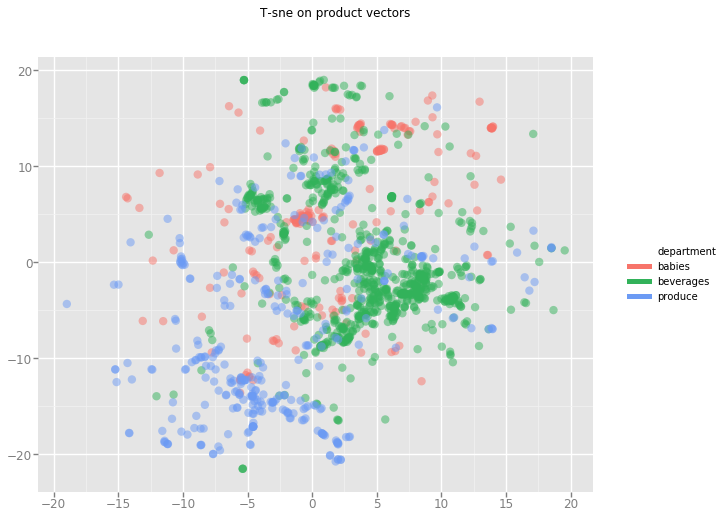

<ggplot: (-9223369104557669025)>

In [40]:
tsne_plot = ggplot(tsne_plot_df, aes(x = "x_tsne", y = "y_tsne", color = "department") ) \
        + geom_point(size = 70, alpha = 0.5) \
        + ggtitle("T-sne on product vectors") \
        + xlab(" ") + ylab(" ")
tsne_plot

---